# NeuroMANCER demonstration: MARS review

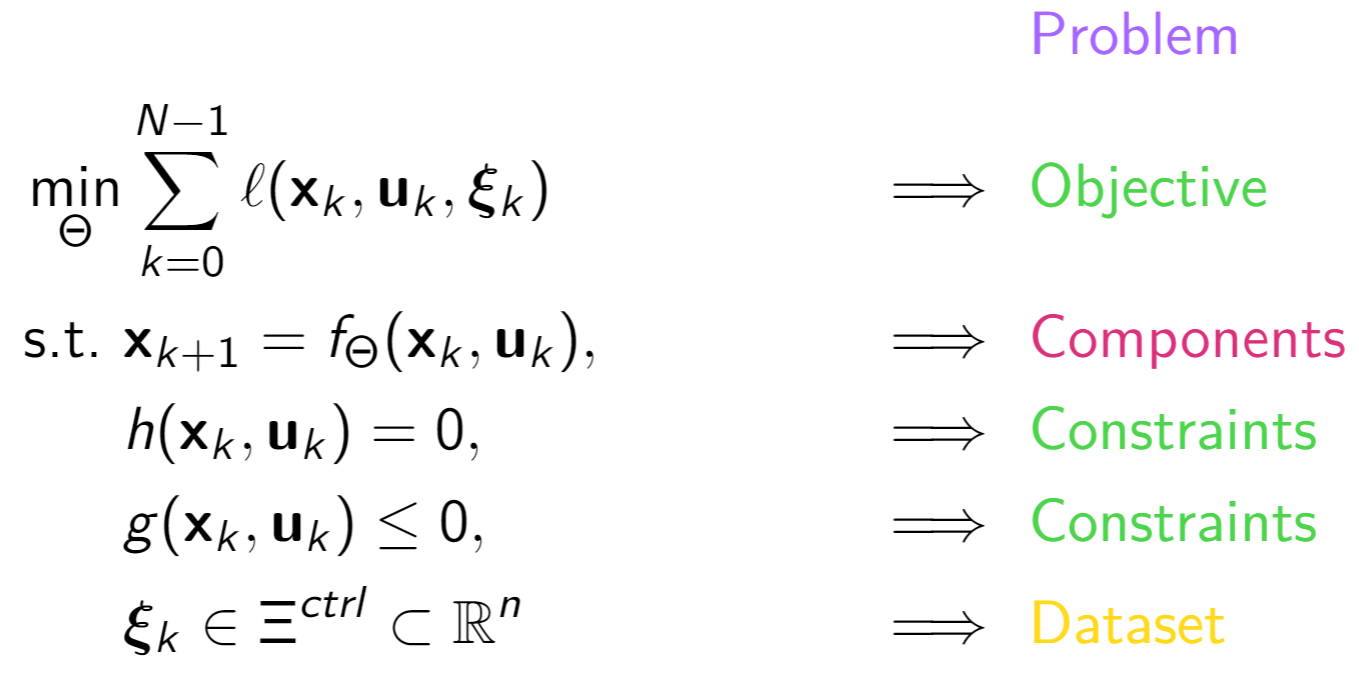

In [1]:
from IPython.display import Image
import warnings
Image('../figs/Problem_neuromancer4.PNG', width=500)

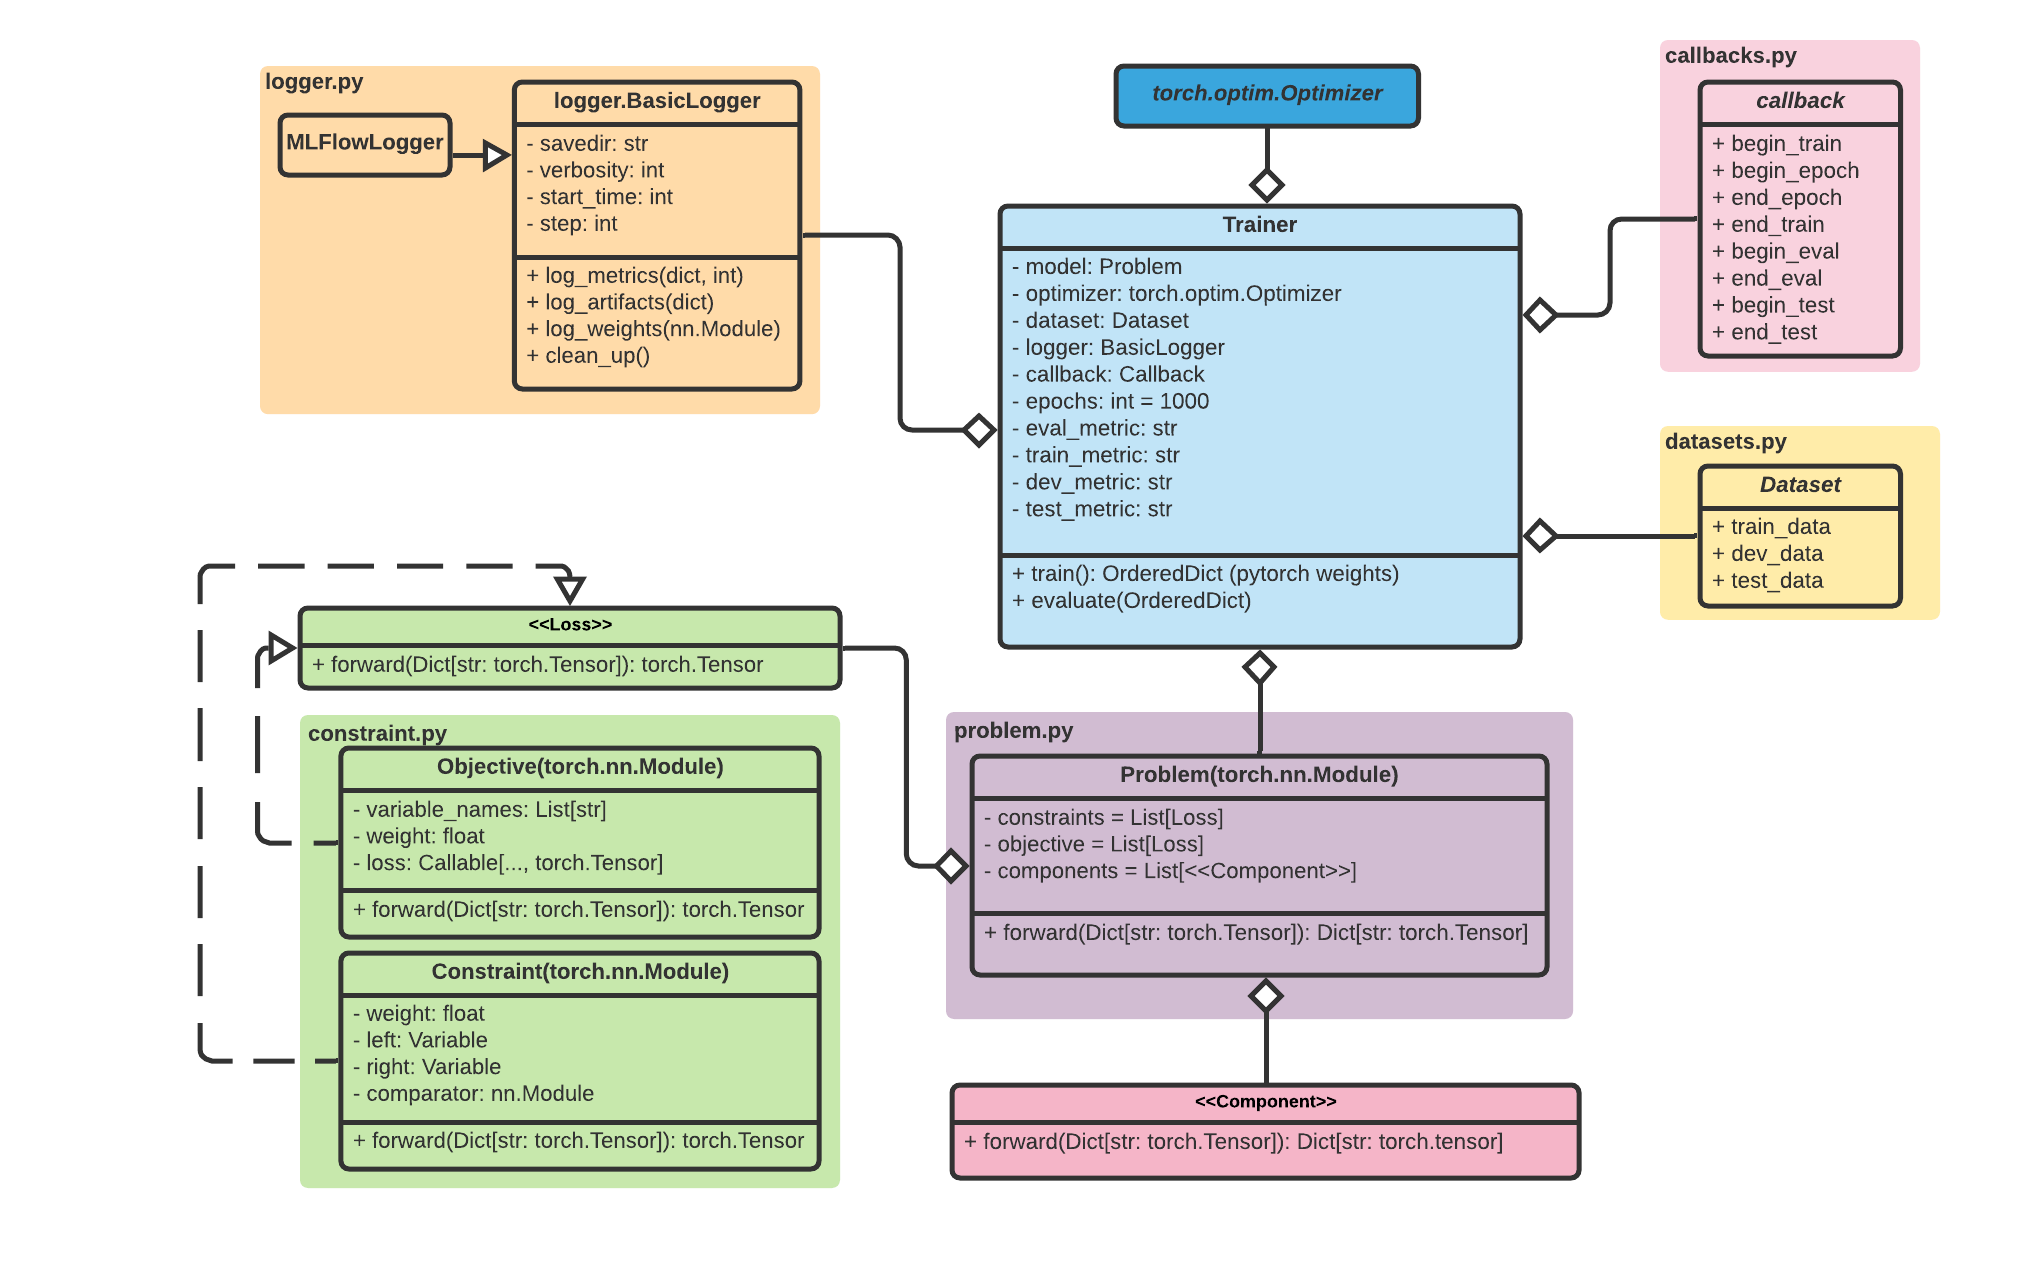

In [2]:
from neuromancer.datasets import FileDataset
from neuromancer.estimators import LinearEstimator
from neuromancer.blocks import Linear, ResMLP, MLP
from neuromancer.dynamics import BlockSSM
from neuromancer.problem import Problem
from neuromancer.simulators import OpenLoopSimulator
from neuromancer.loggers import BasicLogger
from neuromancer.visuals import VisualizerOpen
from neuromancer.trainer import Trainer
from neuromancer.activations import SoftExponential
from neuromancer.constraint import Variable, Objective
from neuromancer.callbacks import SysIDCallback
from argparse import Namespace
import slim 
import torch

warnings.filterwarnings("ignore")
Image('../figs/class_diagram.png')

# System ID

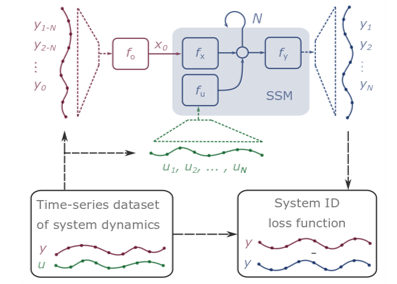

In [3]:
Image('../figs/sysid.png')

## Datasets


In [4]:
dataset = FileDataset(system="aero", 
                      nsteps=8,
                      norm=["Y", "U"])

ny = dataset.dims["Yf"][-1]
nu = dataset.dims["Uf"][-1]
nx = 64
print({k:v.shape for k, v in dataset.train_data.items()})

{'Yp': torch.Size([8, 20, 5]), 'Yf': torch.Size([8, 20, 5]), 'Up': torch.Size([8, 20, 10]), 'Uf': torch.Size([8, 20, 10])}


In [64]:
dataset = FileDataset(system="vehicle3", 
                      nsteps=64,
                      norm=["Y", "U"])

ny = dataset.dims["Yf"][-1]
nu = dataset.dims["Uf"][-1]
nx = 64
print({k:v.shape for k, v in dataset.train_data.items()})

{'Yp': torch.Size([64, 12, 3]), 'Yf': torch.Size([64, 12, 3]), 'Up': torch.Size([64, 12, 5]), 'Uf': torch.Size([64, 12, 5])}


## State Estimator

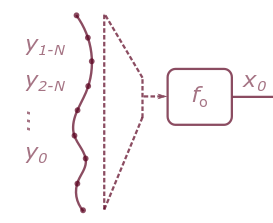

In [65]:
Image('../figs/state_estimator.png', width=200)

In [66]:
# create an estimator for initial system states
dims = {**dataset.dims, "x0": (nx,)}
state_estimator = LinearEstimator(dims, # dict mapping dataset variable names to their dimensions
                                  input_keys=["Yp"])  # names of dataset variables used as input)

## State Space Model

Block-structured state space models decouple the dynamics of exogenous inputs, state transitions, and system measurements. 

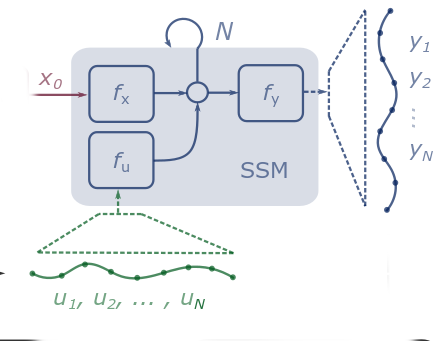

In [67]:
Image('../figs/ssm.png', width=300)

In [68]:
# define state transition map
fx = MLP(nx, nx)

# define output map
fy = Linear(nx, ny)

# define input map
fu = MLP(nu, nx)

# create block-structured state space model
ssm = BlockSSM(fx, fy, fu=fu, input_keys={"x0": f"x0_{state_estimator.name}"}, name="dynamics")

## Objective Terms
To optimize the weights of our model, we'll use mean-squared error as our objective to minimize the error between ground-truth and neural SSM predictions.

In [69]:
predictions = Variable(f"Y_pred_{ssm.name}")
truth = Variable("Yf")
xhat = Variable(f"X_pred_{ssm.name}")
 
smoothing_loss = (xhat[:-1] == xhat[1:])^2
ssm_objective = (predictions == truth)^2
ssm_objective.name = 'ssm_loss'
lower_bound = (predictions > 0.)^2
upper_bound = (predictions < 1.)^2

## Optimization Problem

Now we compose an optimization problem from model components, objective terms, and constraints using NeuroMANCER's `Problem` class.

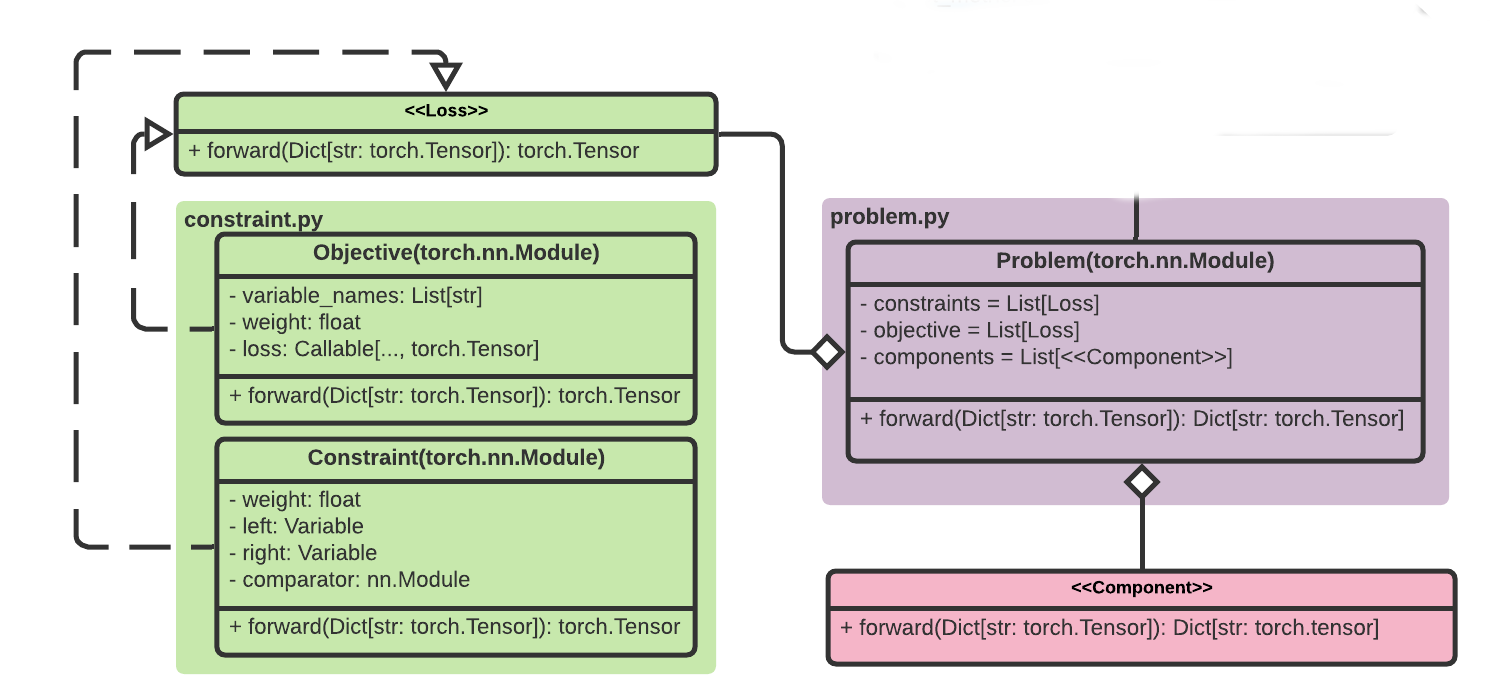

In [27]:
Image('../figs/problem_uml.png')

In [78]:
components = [state_estimator, ssm]
objectives = [ssm_objective]

constraints = [0.01*upper_bound, 0.01*lower_bound, 0.003*smoothing_loss]

model = Problem(objectives, constraints, components)

## Training

The `Trainer` class encapsulates boilerplate training, evaluation, and logging code, and additionally provides options for customized steps (e.g. visualizations, open loop simulations) via a Callback object. 

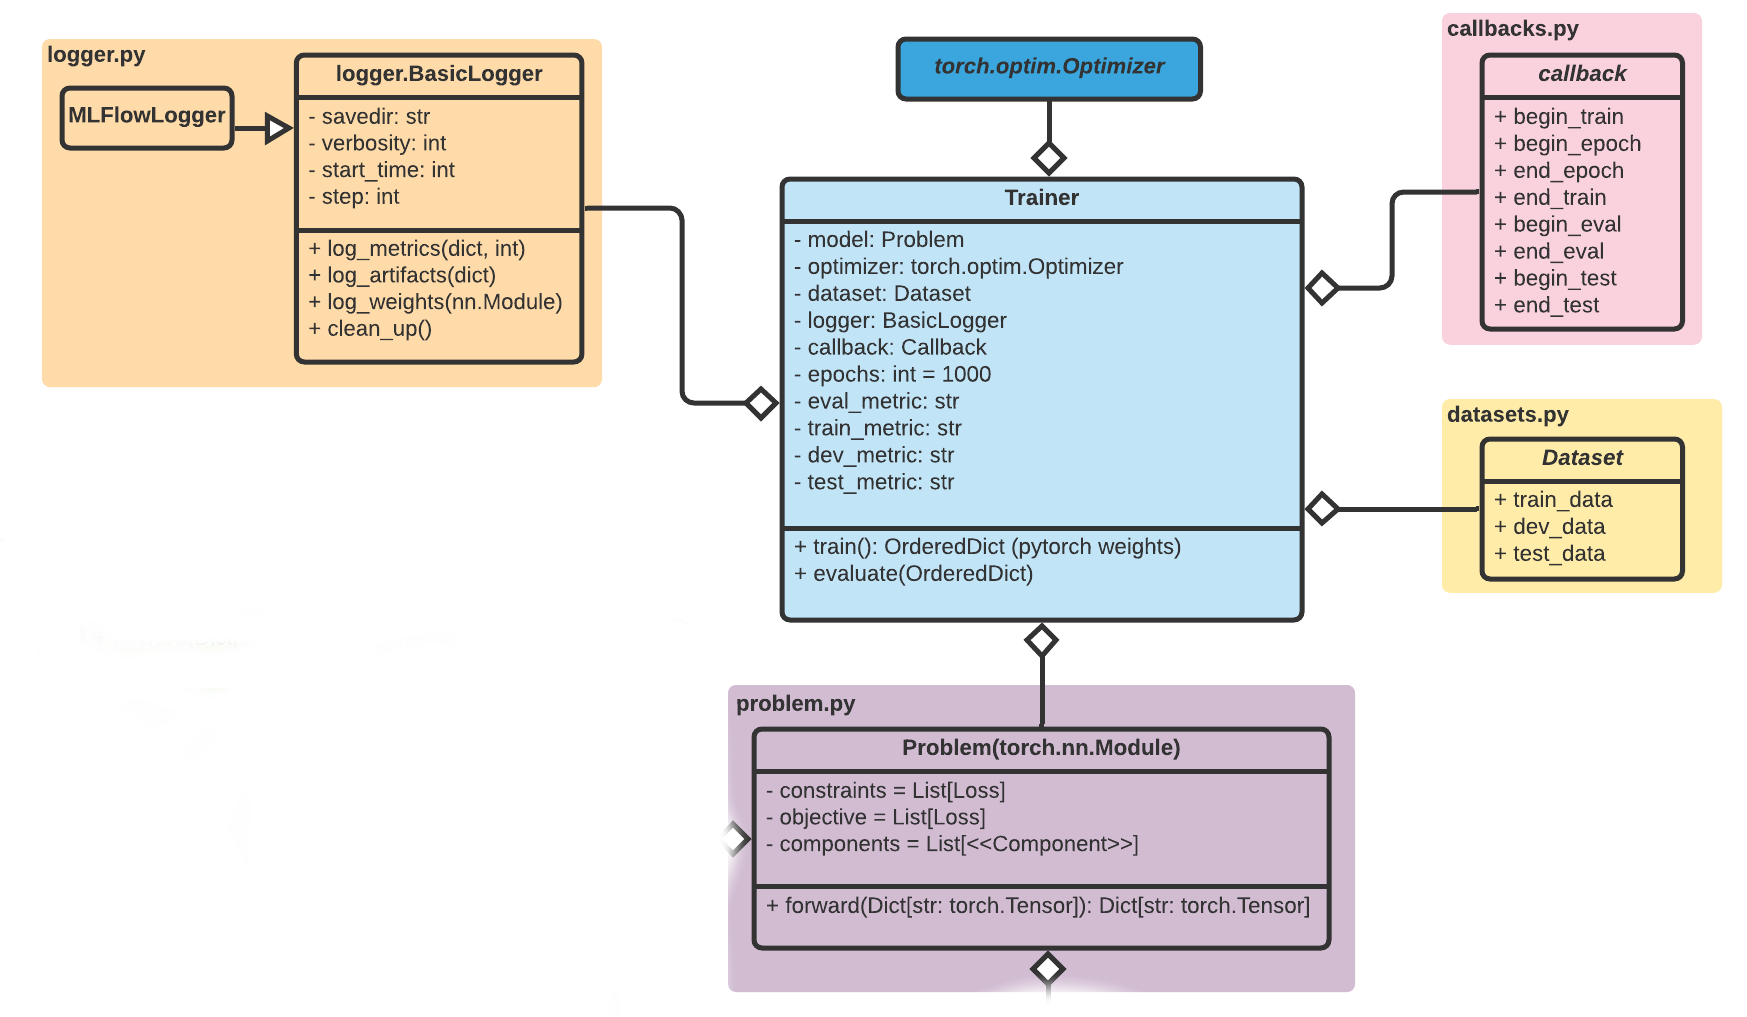

In [71]:
Image('../figs/trainer_uml.png', width=700)

In [83]:
optim = torch.optim.AdamW(model.parameters(), lr=0.000001)
simulator = OpenLoopSimulator(model, dataset, eval_sim=False)

logger = BasicLogger(verbosity=50, savedir='test', stdout=["nstep_dev_ssm_loss", 
                                                           "open_dev_ssm_loss"])
visualizer = VisualizerOpen(dataset, ssm, 1, "test")

trainer = Trainer(
        model,
        dataset,
        optim,
        logger=logger,
        callback=SysIDCallback(simulator, visualizer),
        epochs=1000,
        patience=100,
        eval_metric="nstep_dev_ssm_loss",
    )

None
Number of parameters: 26307


In [84]:
best_model = trainer.train()

epoch: 0	nstep_dev_ssm_loss: 0.03409	eltime:  0.91939
epoch: 50	nstep_dev_ssm_loss: 0.03410	eltime:  2.98870
epoch: 100	nstep_dev_ssm_loss: 0.03412	eltime:  5.05425


## Model Evaluation

In [24]:
linear_model = best_model

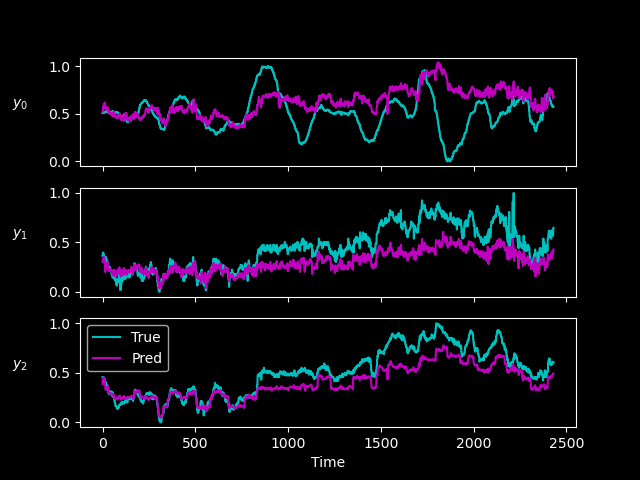

In [85]:
best_outputs = trainer.test(best_model)
Image('test/open_loop.png')

## Analysis of learned dynamics

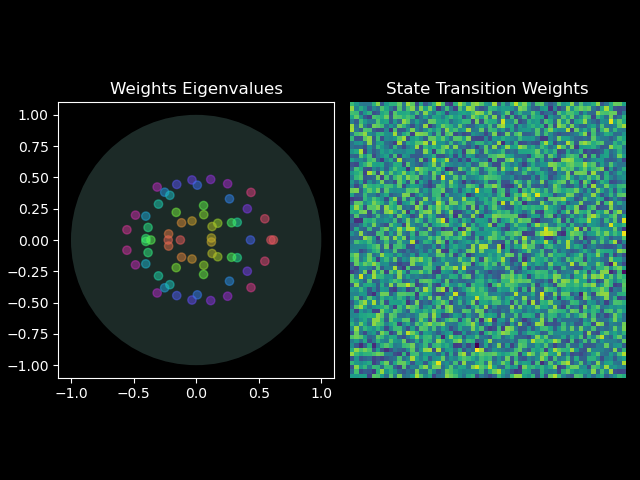

In [17]:
Image('test/eigmat.png')


## Inductive priors

In [24]:
linargs = {'sigma_min': 1.5, 'sigma_max': 2}

fx = Linear(nx, nx, linear_map=slim.maps['pf'], linargs=linargs)

In [25]:
state_estimator = LinearEstimator(dims, # dict mapping dataset variable names to their dimensions
                                  input_keys=["Yp"])  # names of dataset variables used as input)
# define output map
fy = Linear(nx, ny)

# define input map
fu = Linear(nu, nx)

# create block-structured state space model
ssm = BlockSSM(fx, fy, fu=fu, input_keys={"x0": f"x0_{state_estimator.name}"}, name="dynamics")

model = Problem(objectives, constraints, components)
components = [state_estimator, ssm]
objectives = [ssm_objective]
constraints = []

None
Number of parameters: 10885
epoch: 0	nstep_dev_ssm_loss: 0.40562	eltime:  0.00898
epoch: 50	nstep_dev_ssm_loss: 0.28884	eltime:  0.38102
epoch: 100	nstep_dev_ssm_loss: 0.27517	eltime:  0.76969
epoch: 150	nstep_dev_ssm_loss: 0.27093	eltime:  1.14598
epoch: 200	nstep_dev_ssm_loss: 0.25925	eltime:  1.52663
epoch: 250	nstep_dev_ssm_loss: 0.24530	eltime:  1.92870
epoch: 300	nstep_dev_ssm_loss: 0.23168	eltime:  2.32084
epoch: 350	nstep_dev_ssm_loss: 0.21919	eltime:  2.69714
epoch: 400	nstep_dev_ssm_loss: 0.20795	eltime:  3.09052
epoch: 450	nstep_dev_ssm_loss: 0.19789	eltime:  3.50136
epoch: 500	nstep_dev_ssm_loss: 0.18896	eltime:  3.90656
epoch: 550	nstep_dev_ssm_loss: 0.18112	eltime:  4.35998
epoch: 600	nstep_dev_ssm_loss: 0.17435	eltime:  4.78066
epoch: 650	nstep_dev_ssm_loss: 0.16862	eltime:  5.24009
epoch: 700	nstep_dev_ssm_loss: 0.16387	eltime:  5.75297
epoch: 750	nstep_dev_ssm_loss: 0.15998	eltime:  6.23092
epoch: 800	nstep_dev_ssm_loss: 0.15679	eltime:  6.66569
epoch: 850	nstep_d

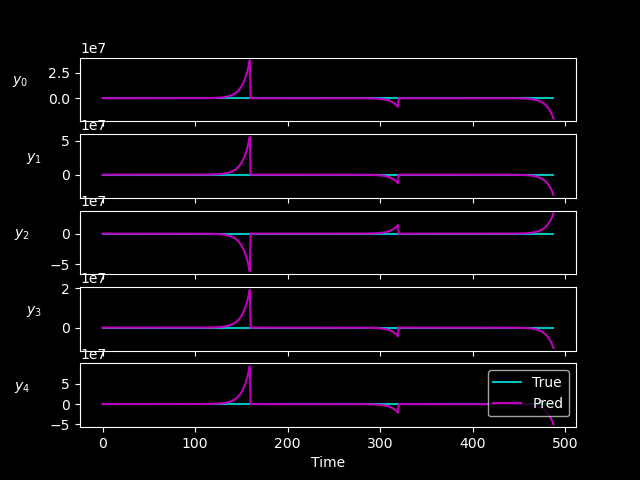

In [26]:
optim = torch.optim.AdamW(model.parameters(), lr=0.0001)
simulator = OpenLoopSimulator(model, dataset, eval_sim=False)

logger = BasicLogger(verbosity=50, savedir='test', stdout=["nstep_dev_ssm_loss", 
                                                           "open_dev_ssm_loss"])
visualizer = VisualizerOpen(dataset, ssm, 1, "test")

trainer = Trainer(
        model,
        dataset,
        optim,
        logger=logger,
        callback=SysIDCallback(simulator, visualizer),
        epochs=1000,
        patience=100,
        eval_metric="nstep_dev_ssm_loss",
    )
best_model = trainer.train()
best_outputs = trainer.test(best_model)
Image('test/open_loop.png')

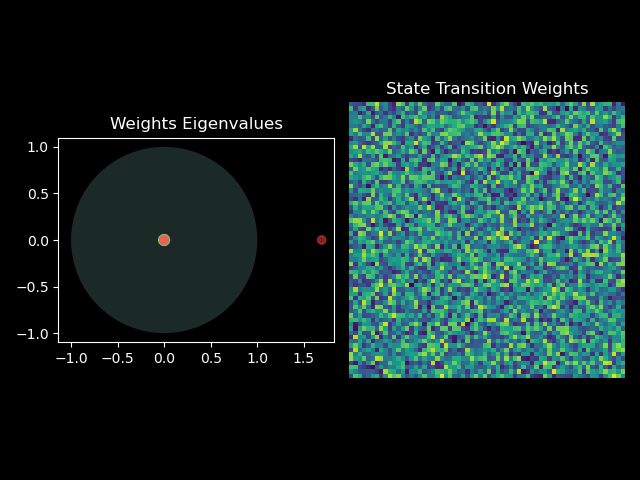

In [28]:
Image('test/eigmat.png')


## Domain Aware Priors

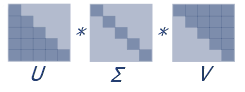

In [44]:
linargs = {'sigma_min': 0.1, 'sigma_max': 1.0}
fx = MLP(nx, nx, hsizes=[64, 64,64],linear_map=slim.maps['softSVD'], linargs=linargs)

reg = Variable(f'reg_error_{ssm.name}')
svd_error = (reg == 0.0)^2

Image('../figs/svd.png', width=300)

## Constraint Terms
In addition to minimizing the mean-squared error of predicted and expected observables, we may also want to impose further constraints on different model components to enforce certain model behaviors. 

In [45]:
state_predictions = Variable(f"X_pred_{ssm.name}")
initial_states = Variable(f"x0_{state_estimator.name}")

dx_penalty = (state_predictions[1:] == state_predictions[:-1])^2

In [46]:
state_estimator = LinearEstimator(dims, # dict mapping dataset variable names to their dimensions
                                  input_keys=["Yp"])  # names of dataset variables used as input)
# define output map
fy = Linear(nx, ny)

# define input map
fu = Linear(nu, nx)

# create block-structured state space model
ssm = BlockSSM(fx, fy, fu=fu, input_keys={"x0": f"x0_{state_estimator.name}"}, name="dynamics")

model = Problem(objectives, constraints, components)
components = [state_estimator, ssm]
objectives = [ssm_objective]
constraints = [0.1*dx_penalty, 0.1*svd_error]

None
Number of parameters: 15045
epoch: 0	nstep_dev_ssm_loss: 0.02573	eltime:  0.01653
epoch: 50	nstep_dev_ssm_loss: 0.02377	eltime:  0.53042
epoch: 100	nstep_dev_ssm_loss: 0.02312	eltime:  1.04756
epoch: 150	nstep_dev_ssm_loss: 0.02269	eltime:  1.65919
epoch: 200	nstep_dev_ssm_loss: 0.02198	eltime:  2.29721
epoch: 250	nstep_dev_ssm_loss: 0.02083	eltime:  2.90727
epoch: 300	nstep_dev_ssm_loss: 0.01950	eltime:  3.45094
epoch: 350	nstep_dev_ssm_loss: 0.01794	eltime:  4.01714
epoch: 400	nstep_dev_ssm_loss: 0.01645	eltime:  4.51741
epoch: 450	nstep_dev_ssm_loss: 0.01496	eltime:  5.03193
epoch: 500	nstep_dev_ssm_loss: 0.01352	eltime:  5.55911
epoch: 550	nstep_dev_ssm_loss: 0.01224	eltime:  6.06078
epoch: 600	nstep_dev_ssm_loss: 0.01105	eltime:  6.61536
epoch: 650	nstep_dev_ssm_loss: 0.00998	eltime:  7.19517
epoch: 700	nstep_dev_ssm_loss: 0.00906	eltime:  7.74329
epoch: 750	nstep_dev_ssm_loss: 0.00824	eltime:  8.34696
epoch: 800	nstep_dev_ssm_loss: 0.00753	eltime:  8.86165
epoch: 850	nstep_d

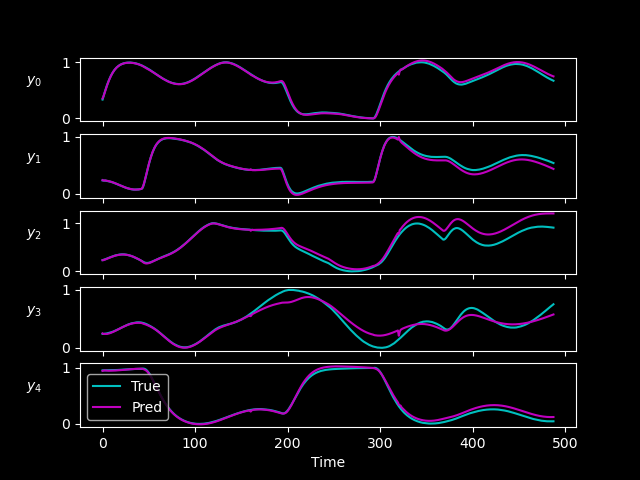

In [48]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
simulator = OpenLoopSimulator(model, dataset, eval_sim=False)

logger = BasicLogger(verbosity=50, savedir='test', stdout=["nstep_dev_ssm_loss", 
                                                           "open_dev_ssm_loss"])
visualizer = VisualizerOpen(dataset, ssm, 1, "test")

trainer = Trainer(
        model,
        dataset,
        optim,
        logger=logger,
        callback=SysIDCallback(simulator, visualizer),
        epochs=1000,
        patience=100,
        eval_metric="nstep_dev_ssm_loss",
    )
best_model = trainer.train()
best_outputs = trainer.test(best_model)
Image('test/open_loop.png')

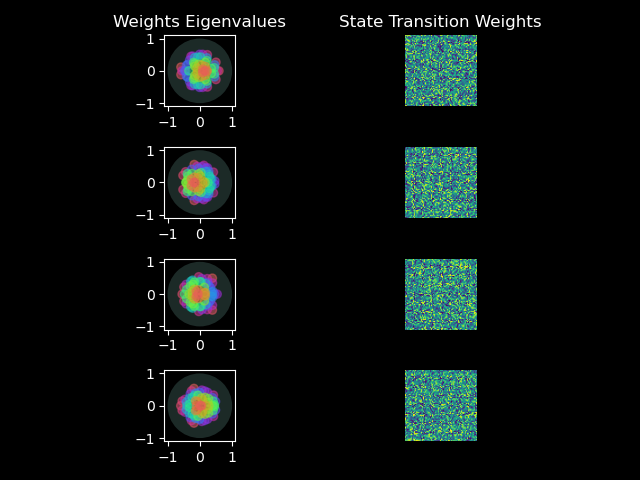

In [49]:
Image('test/eigmat.png')

## Impact

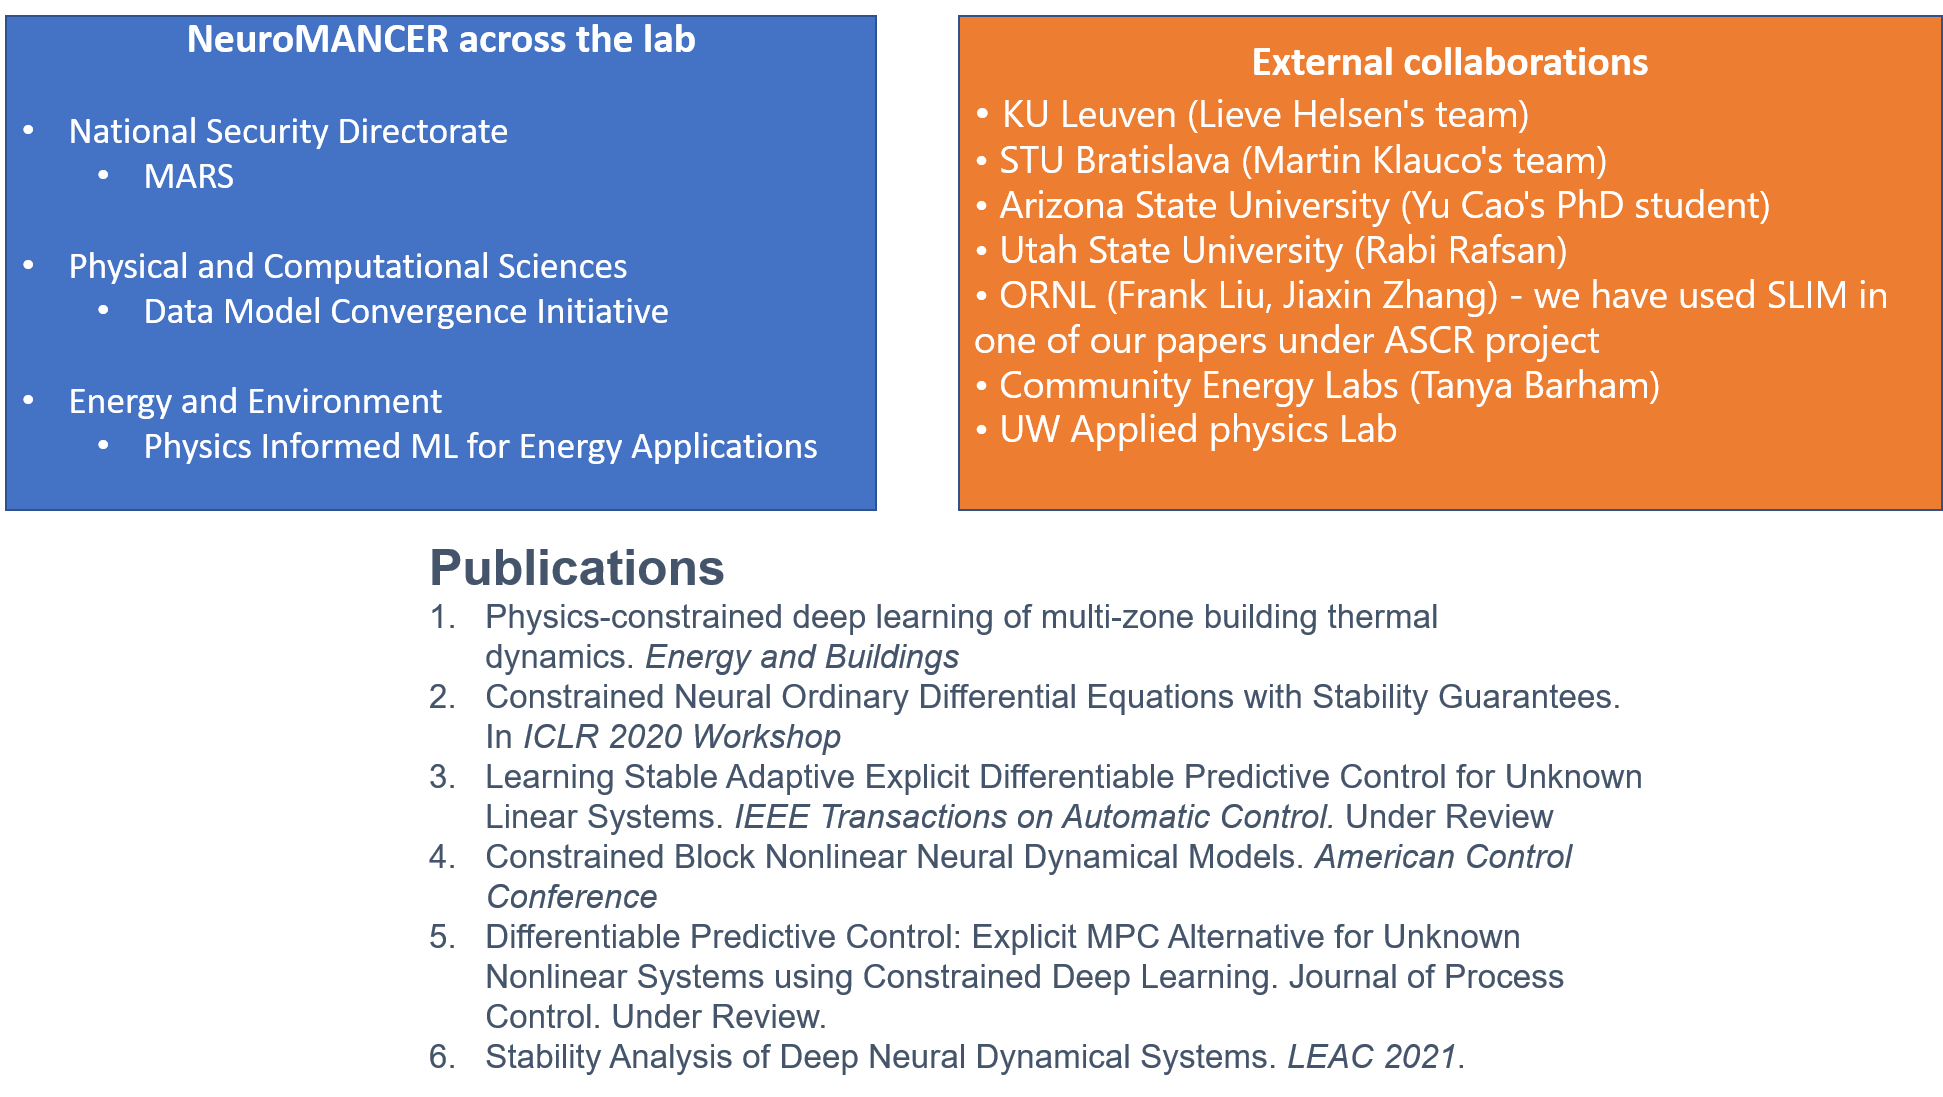

In [50]:
Image('../figs/metrics.png')

## Transition

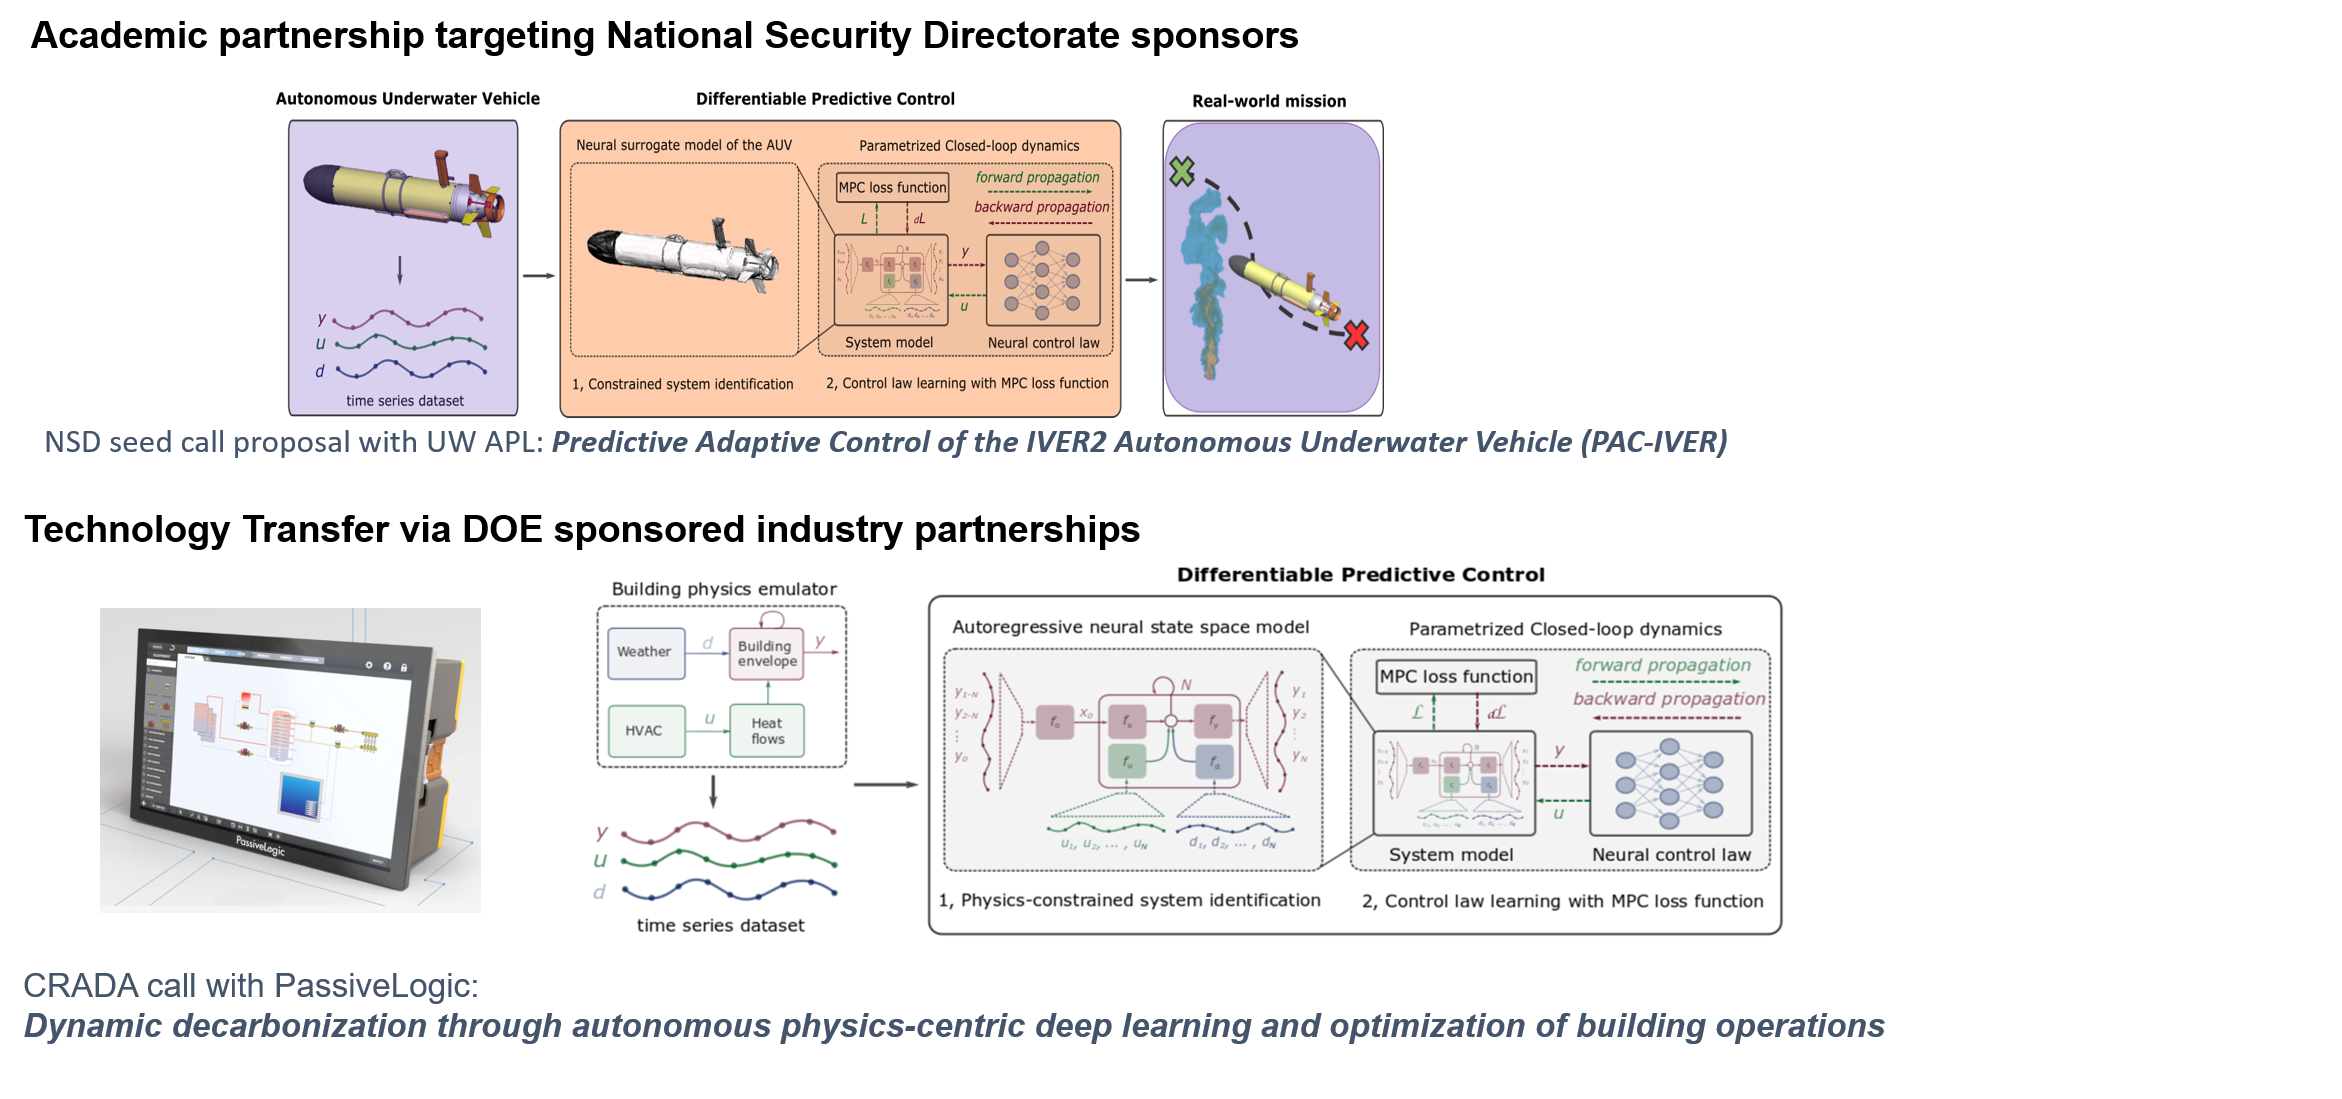

In [51]:
Image('../figs/funding.png')